In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.stats import poisson

def norm(x, mean):
    return np.exp(-(x-mean)**2/2/mean) / np.sqrt(2*np.pi*mean)

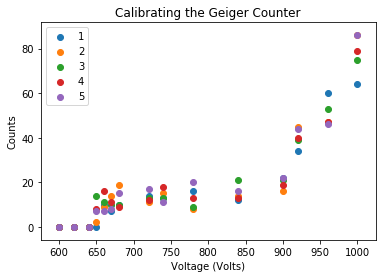

In [2]:
df = pd.read_excel('geiger_calibration.xlsx')
X = df.values
for i in range(1, len(X[0])):
    plt.scatter(X[:, 0], X[:,i])
    
plt.title('Calibrating the Geiger Counter')
plt.ylabel('Counts')
plt.xlabel('Voltage (Volts)')
plt.legend([1,2,3,4,5])
plt.show()

                   mean      std      var  mean error  var error    delta  \
mean               2.25  1.61954  2.62291    0.086603   0.162289  0.37291   
std                2.25  1.61954  2.62291    0.086603   0.162289  0.37291   
var                2.25  1.61954  2.62291    0.086603   0.162289  0.37291   
mean error         2.25  1.61954  2.62291    0.086603   0.162289  0.37291   
var error          2.25  1.61954  2.62291    0.086603   0.162289  0.37291   
delta              2.25  1.61954  2.62291    0.086603   0.162289  0.37291   
delta uncertainty  2.25  1.61954  2.62291    0.086603   0.162289  0.37291   

                   delta uncertainty  
mean                        0.183951  
std                         0.183951  
var                         0.183951  
mean error                  0.183951  
var error                   0.183951  
delta                       0.183951  
delta uncertainty           0.183951  

raw bins [0 1 2 3 4 5 6 7 9] 
raw counts [37 68 84 53 30 16  6  5  1]


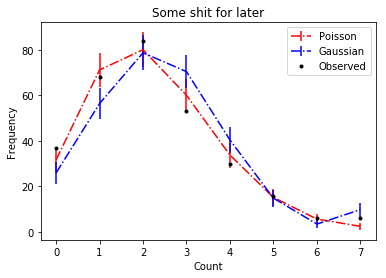

In [107]:
# load data and format for analysis
df1 = pd.read_excel('0.1min_interval_geiger.xlsx', header=None)
params = df1[0].describe()
N = params[0]
mean = params[1]
std = params[2]
var = params[2]**2
mean_uncertainty = np.sqrt(mean)/np.sqrt(N)
var_uncertainty = np.sqrt(2*mean**2-mean)/np.sqrt(N-1)
metrics = {}
metrics.update({'mean':mean})
metrics.update({'std':std})
metrics.update({'var':var})
metrics.update({'mean error':mean_uncertainty})
metrics.update({'var error': var_uncertainty})
metrics.update({'delta': abs(mean-var)})
metrics.update({'delta uncertainty': np.sqrt(mean_uncertainty**2 + var_uncertainty**2)})
metrics = pd.DataFrame(data=metrics, index=metrics.keys())
print(metrics)


counts = df1.values
counts = np.ndarray.flatten(counts)
x, y = np.unique(counts, return_counts=True)
print('\nraw bins', x, '\nraw counts', y)

pvals = []
Counts = []
# rewrite this loop to obtain left probability values
for i in range(7):
    pvals.append([poisson.pmf(i, mean), norm(i, mean)])
    Counts.append(y[i])

Counts.append(0)
# adjust the condition to find the right tail bin count
Counts[-1] = np.sum(y[np.argwhere(x>=7)])

    
print('\nBinned counts',Counts)
    
temp = np.array(pvals)
pvals.append([1-np.sum(temp[:,0]), 1-np.sum(temp[:,1])])

temp = np.array(pvals)
print('\n','these should be 1',np.sum(temp[:,0]), np.sum(temp[:,1]))

bin_uncertainties = []
for p, g in pvals:
    bin_uncertainties.append([np.sqrt(N*p*(1-p)), np.sqrt(N*g*(1-g))])
    
temp = np.array(bin_uncertainties)

print('\n\n Poisson uncertainties',temp[:,0], '\n\nGaussian uncertainties', temp[:,1], '\n')

x = np.arange(x[0], x[0]+len(temp))

print('\n\nThese should be equal', len(Counts), len(bin_uncertainties), len(x), len(pvals))

bin_uncertainties = np.array(bin_uncertainties)
pvals = np.array(pvals)
Counts = np.array(Counts)

fvals = N*np.array(pvals)

chi2 = []

for f, o, sigma in zip(fvals, Counts, bin_uncertainties):
    pchi = ((f[0]-o)/sigma[0])**2
    gchi = ((f[1]-o)/sigma[1])**2
    chi2.append([pchi,gchi])
    
chi2 = np.array(chi2)

chi2p = np.sum(chi2[:,0])
chi2g = np.sum(chi2[:,1])

print('\n\n')
print('The poisson Chi2 is {}, the gaussian Chi2 is {}, the expected Chi2 is {}, with deviation {}'.format(chi2p, chi2g, len(Counts)-1, np.sqrt(2*(len(Counts)-1))))
plt.errorbar(x, fvals[:,0], yerr=bin_uncertainties[:,0], fmt='-.r')
plt.errorbar(x, fvals[:,1], yerr=bin_uncertainties[:,1], fmt='-.b')
plt.errorbar(x, Counts, fmt='.k')
plt.title('Some shit for later')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.legend(['Poisson', 'Gaussian', 'Observed'])